In [1]:
# This will load the calibrated values and calculate the expected cross sections for each of the two energy bins and the
# two DECT spectra

import os
import numpy as np

directory = r'Material_decomposition_data\Calibration_and_test_data'
load_folder_pcd = '23_08_26_CT_inserts_PCD'
load_folder = '23_08_26_CT_inserts_80'

low_t1, low_t2 = 35, 50  # Low energy range
high_t1, high_t2 = 65, 95  # High energy range

low_eff = 42.7  # Low bin effective energy (keV)
high_eff = 76.4  # High bin effective energy (keV)
eff_80 = 44.9  # 80 kVp effective energy (keV)
eff_120 = 58.9  # 80 kVp effective energy (keV)

calib_path_pcd = os.path.join(directory, load_folder_pcd, 'Calibrated_values')
b_low, b_high = np.load(os.path.join(calib_path_pcd, f'B_{low_t1}-{low_t2}_{high_t1}-{high_t2}_M5_ideal_mean.npy'))

calib_path_80 = os.path.join(directory, load_folder, 'Calibrated_values')
b_80, b_120 = np.load(os.path.join(calib_path_80, f'B_25-80_25-120_M3.npy'))


2.3435305062282135
-1.368940289467068 0.8352061999021635 2.3460368960187377 1.4894725396649622
0.2599007204060324 0.18808132982002618 0.27812601170375145 0.22974895448385174
-2.2475347278047337 1.8948612369537798 3.599337893653557 2.766357768081198


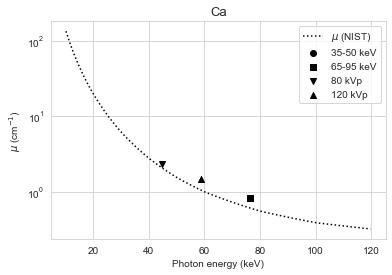

In [3]:
# This will take a given Z and calculate a theoretical electronic cross section for a given Z value, it will also load the electronic cross section of water

import os
import numpy as np
from filter_spectrum import filter_spectrum
from interp_attenuation import log_interp_1d
import matplotlib.pyplot as plt
from find_nearest import find_nearest_index
import seaborn as sns

elements = ['H', 'O', 'C', 'N', 'Cl', 'Ca', 'P', 'Mg', 'Si']
zs = [1, 8, 6, 7, 17, 20, 15, 12, 14]
a_mol = [1.008, 15.999, 12.011, 14.007, 35.45, 40.08, 30.97376, 24.305, 28.085]
den = [0.00008988, 0.001429, 2.267, 0.0012506, 0.003214, 1.54, 1.82, 1.74, 2.3296]

ne_h2o = 0.111898 * 1/1.008 + 0.888102 * 8/15.999

z_idx = 5
z_name = elements[z_idx]
z = zs[z_idx]
a = a_mol[z_idx]
rho = den[z_idx]

ne = rho * z / a
ne = 2.7 * 13 / 26.982

print(ne/ne_h2o)

att_dir = r'Material_decomposition_data\K-edge Decomposition\Material Decomposition Inserts'
z_att = np.loadtxt(os.path.join(att_dir, 'Elements', f'lin_{z_name}.txt'))
h2o = np.loadtxt(os.path.join(att_dir, f'H2O.txt'))

spec_folder = r'Material_decomposition_data\K-edge Decomposition\Beam Spectrum'
beam = np.load(os.path.join(spec_folder, 'corrected-spectrum_120kV.npy'))
beam80 = np.load(os.path.join(spec_folder, '80kV.npy'))

# Filter the spectrum
beam = filter_spectrum(beam, 'Al', 6)
energies = beam[:, 0]
spectrum = beam[:, 1]

energies80 = beam80[:, 0] / 1000 # Convert to MeV
spectrum80 = beam80[:, 1]

# Interpolate the attenuation of the element and water into the energies of the spectrum
interp_func = log_interp_1d(z_att[:, 0], z_att[:, 1])
z_att = interp_func(energies)

interp_h2o = log_interp_1d(h2o[:, 0], h2o[:, 1])
h2o_120 = interp_h2o(energies)
h2o_80 = interp_h2o(energies80)

low_spectrum = np.copy(spectrum)
lt1i = find_nearest_index(energies * 1000, low_t1)
lt2i = find_nearest_index(energies * 1000, low_t2)
low_spectrum[0:lt1i] = 0
low_spectrum[lt2i + 1:] = 0

high_spectrum = np.copy(spectrum)
ht1i = find_nearest_index(energies * 1000, high_t1)
ht2i = find_nearest_index(energies * 1000, high_t2)
high_spectrum[0:ht1i] = 0
high_spectrum[ht2i + 1:] = 0

low_h2o = np.average(h2o_120, weights=low_spectrum)
high_h2o = np.average(h2o_120, weights=high_spectrum)

spectrum_80 = np.copy(spectrum80)
lt1i = find_nearest_index(energies80 * 1000, 25)
lt2i = find_nearest_index(energies80 * 1000, 80)
spectrum_80[0:lt1i] = 0
spectrum_80[lt2i + 1:] = 0

spectrum_120 = np.copy(spectrum)
ht1i = find_nearest_index(energies * 1000, 25)
ht2i = find_nearest_index(energies * 1000, 120)
spectrum_120[0:ht1i] = 0
spectrum_120[ht2i + 1:] = 0

low_h20_80 = np.average(h2o_80, weights=spectrum_80)
high_h2o_120 = np.average(h2o_120, weights=spectrum_120)

mu_low = low_h2o * ne / ne_h2o * np.sum(b_low * np.power(z * np.ones(5), (np.arange(5))))
mu_high = high_h2o * ne / ne_h2o * np.sum(b_high * np.power(z * np.ones(5), (np.arange(5))))

mu_80 = low_h20_80 * ne / ne_h2o * np.sum(b_80 * np.power(z * np.ones(3), (np.arange(3))))
mu_120 = high_h2o_120 * ne / ne_h2o * np.sum(b_120 * np.power(z * np.ones(3), (np.arange(3))))

print(mu_low, mu_high, mu_80, mu_120)
print(low_h2o, high_h2o, low_h20_80, high_h2o_120)
print(np.sum(b_low * np.power(z * np.ones(5), (np.arange(5)))), np.sum(b_high * np.power(z * np.ones(5), (np.arange(5)))), np.sum(b_80 * np.power(z * np.ones(3), (np.arange(3)))), np.sum(b_120 * np.power(z * np.ones(3), (np.arange(3)))))

sns.set_style('whitegrid')
fig = plt.figure(figsize=(6, 4))
plt.semilogy(energies * 1000, z_att, color='k', ls=':')
plt.scatter(low_eff, mu_low, color='k', marker='o')
plt.scatter(high_eff, mu_high, color='k', marker='s')
plt.scatter(eff_80, mu_80, color='k', marker='v')
plt.scatter(eff_120, mu_120, color='k', marker='^')
plt.legend([r'$\mu$ (NIST)', '35-50 keV', '65-95 keV', '80 kVp', '120 kVp'])
plt.xlabel('Photon energy (keV)')
plt.ylabel(r'$\mu$ (cm$^{-1}$)')
plt.title(f'{z_name}', fontsize=13)
plt.show()